<a href="https://colab.research.google.com/github/Luckaz7/Projeto_censo_natalidade_mortalidade_alfenas_mg/blob/feature-02/Projeto_censo_natalidade_mortalidade_alfenas_mg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importação das bibliotecas e modulos necessários para a realização do projeto:**

In [ ]:
from google.colab import drive
from google.colab import auth
from google.colab import userdata
from google.cloud import storage
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO

**Credenciais e configurações iniciais para acesso ao bucket do GCS:**

In [ ]:
drive.mount('/content/drive')
id_projeto = userdata.get('id_projeto').strip("'")
auth.authenticate_user(project_id=id_projeto)
cliente = storage.Client(project=id_projeto)

Mounted at /content/drive


**Função padrão para extração dos dados do arquivo .csv armazenado no google drive:**

In [ ]:
def extracao_dados(dados: str) -> pd.DataFrame:
  try:
    df = pd.read_csv(dados, sep=';')
    print(f'Dados extraidos com sucesso: {len(df)}')
    return df
  except Exception as e:
    print(f'Ocorreu um erro ao extrair os dados: {e}')
    return None

**Função para padronização e formatação dos nomes das colunas para facilitar a manipulação:**

In [ ]:
def padronizacao_dados(dados: pd.DataFrame) -> pd.DataFrame:
  try:
    df = dados.copy()
    df.columns = df.columns.str.lower()
    df = df.reset_index(drop=True)
    return df
  except Exception as e:
    print(f'Ocorreu um erro na padronização das colunas: {e}')
    return dados

**Função padrão para a carga dos dados no bucket do GCS:**

In [ ]:
def carga_dados(dados: pd.DataFrame, destino: str, bucket: str) -> str:
  try:
    df = dados.copy()
    buffer = BytesIO()
    df.to_parquet(buffer, index=False)
    buffer.seek(0)
    bucket = cliente.bucket(bucket)
    blob = bucket.blob(destino)
    blob.upload_from_file(buffer, content_type='application/octet-stream')
    return f'Dados enviados com sucesso para: {destino}'
  except Exception as e:
    print(f'Ocorreu um erro ao fazer a carga dos dados: {e}')
    return dados

# **Etapa de Extração:**

In [ ]:
df = extracao_dados('/content/drive/MyDrive/Livros Programação /Engenharia de Dados/Python/Registro civil - Alfenas.csv')
df.head()

Dados extraidos com sucesso: 45


,Nível,Indicador,2004,2005,2006,2007,2008,2009,2010,2011,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unidade
0,1,Casamentos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.1,Registrados no ano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.1.1,Lugar do registro,273.0,308.0,289.0,313.0,274.0,328.0,365.0,364.0,...,391.0,423.0,371.0,356.0,308.0,421.0,360.0,375.0,434.0,casamentos
3,2,Divórcios,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.1,Judicial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Seleção das linhas necessárias para o projeto:**

In [ ]:
filtro = (df['Indicador'].isin(['Hospital', 'Lugar do registro'])) & (df['Unidade'] == 'pessoas')
df_nascidos = df[filtro].loc[[18,20]]
df_obitos = df[filtro].loc[[26,28]]

# **Etapa de padronização e transformação dos dados:**

In [ ]:
df_nascidos = padronizacao_dados(df_nascidos)
df_nascidos = df_nascidos.fillna(0)
df_nascidos.rename(columns={'indicador':'local','unidade':'tipo'}, inplace=True)
df_nascidos.loc[0, 'local'] = 'registro hospitalar'
df_nascidos.loc[1, 'local'] = 'registro CRC'
df_nascidos = df_nascidos[['local','tipo','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023','2024']]

anos = ['2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023','2024']
df_nascidos['total'] = df_nascidos[anos].sum(axis=1).astype(float)
df_nascidos['media'] = df_nascidos[anos].mean(axis=1).astype(float).round(1)
df_nascidos

,local,tipo,2004,2005,2006,2007,2008,2009,2010,2011,...,2017,2018,2019,2020,2021,2022,2023,2024,total,media
0,registro hospitalar,pessoas,0.0,0.0,1031.0,1024.0,1031.0,968.0,953.0,925.0,...,991.0,997.0,1012.0,983.0,948.0,917.0,883.0,910.0,18627.0,887.0
1,registro CRC,pessoas,1046.0,1100.0,1044.0,1069.0,1080.0,1000.0,1008.0,992.0,...,1149.0,1584.0,1668.0,1377.0,1420.0,1449.0,1499.0,1581.0,25521.0,1215.3


In [ ]:
df_obitos = padronizacao_dados(df_obitos)
df_obitos = df_obitos.fillna(0)
df_obitos.rename(columns={'indicador':'local','unidade':'tipo'}, inplace=True)
df_obitos.loc[0, 'local'] = 'registro CRC'
df_obitos.loc[1, 'local'] = 'registro hospitalar'
df_obitos = df_obitos[['local','tipo','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023','2024']]

df_obitos['total'] = df_obitos[anos].sum(axis=1).astype(float)
df_obitos['media'] = df_obitos[anos].mean(axis=1).astype(float).round(1)
df_obitos

,local,tipo,2004,2005,2006,2007,2008,2009,2010,2011,...,2017,2018,2019,2020,2021,2022,2023,2024,total,media
0,registro CRC,pessoas,0.0,0.0,0.0,0.0,689.0,774.0,825.0,959.0,...,1080.0,643.0,597.0,622.0,757.0,708.0,703.0,757.0,13866.0,660.3
1,registro hospitalar,pessoas,0.0,0.0,0.0,0.0,606.0,656.0,726.0,839.0,...,939.0,502.0,455.0,455.0,615.0,551.0,541.0,601.0,11253.0,535.9


# **Etapa de Carga dos dado no bucket do GCS:**

In [ ]:
carga_dados(df_nascidos, 'dados_natalidade/silver/dados_natalidade_limpo.parquet', 'datalake_taxa_natalidade_mortalidade')
carga_dados(df_obitos, 'dados_mortalidade/silver/dados_mortalidade_limpo.parquet', 'datalake_taxa_natalidade_mortalidade')

'Dados enviados com sucesso para: dados_mortalidade/silver/dados_mortalidade_limpo.parquet'

# **Amostragem de Dados: Taxa de Natalidade**

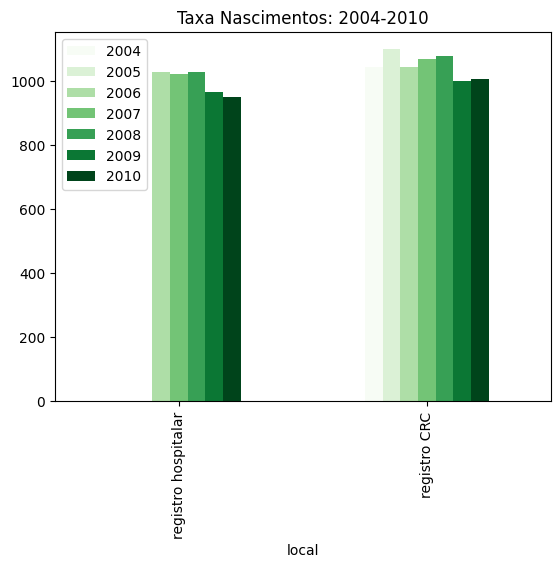

In [ ]:
anos_2004_2010 = ['2004','2005','2006','2007','2008','2009','2010']
df_nascidos.plot(x='local', y=anos_2004_2010, title='Taxa Nascimentos: 2004-2010', kind='bar', cmap='Greens', ax=plt.gca())
plt.show()

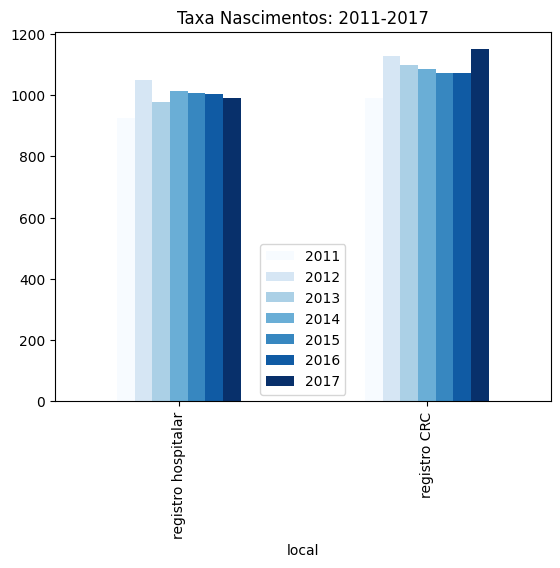

In [ ]:
anos_2011_2017 = ['2011','2012','2013','2014','2015','2016','2017']
df_nascidos.plot(x='local', y=anos_2011_2017, title='Taxa Nascimentos: 2011-2017', kind='bar', cmap='Blues', ax=plt.gca())
plt.show()

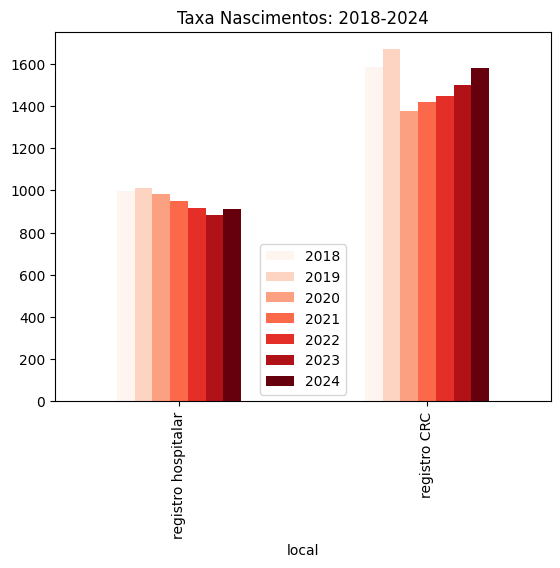

In [ ]:
anos_2018_2024 = ['2018','2019','2020','2021','2022','2023','2024']
df_nascidos.plot(x='local', y=anos_2018_2024, title='Taxa Nascimentos: 2018-2024', kind='bar', cmap='Reds', ax=plt.gca())
plt.show()

# **Amostragem de Dados: Taxa de Mortalidade**

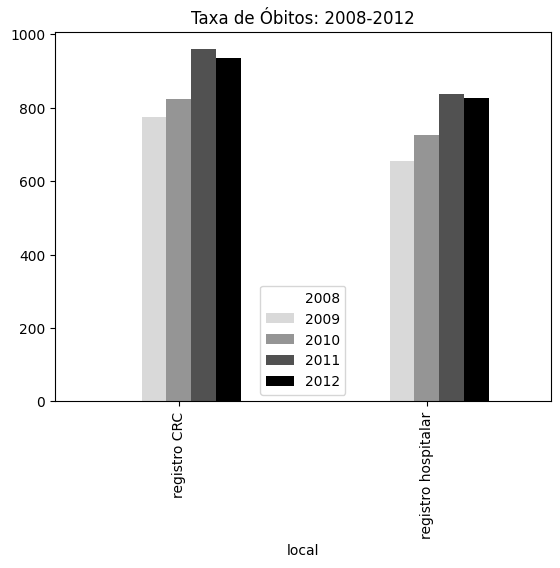

In [ ]:
anos_2008_2012 = ['2008','2009','2010','2011','2012']
df_obitos.plot(x='local', y=anos_2008_2012, title='Taxa de Óbitos: 2008-2012', kind='bar', cmap='Greys', ax=plt.gca())
plt.show()

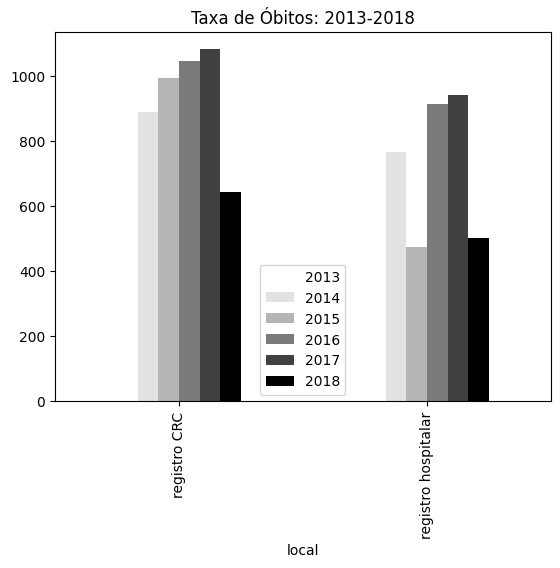

In [ ]:
anos_2013_2018 = ['2013','2014','2015','2016','2017','2018']
df_obitos.plot(x='local', y=anos_2013_2018, title='Taxa de Óbitos: 2013-2018', kind='bar', cmap='Greys', ax=plt.gca())
plt.show()

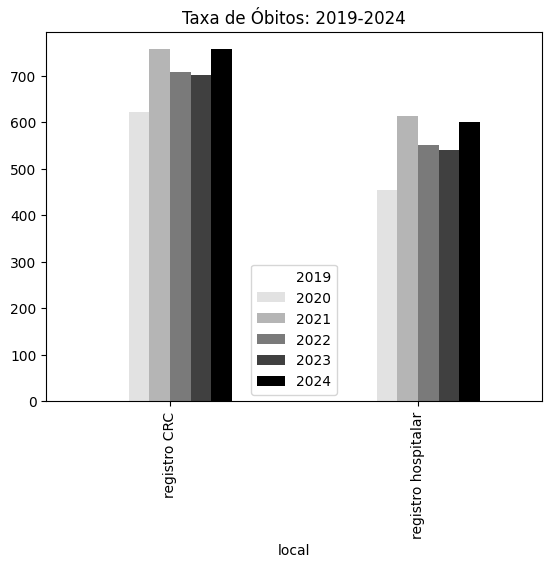

In [ ]:
anos_2019_2024 = ['2019','2020','2021','2022','2023','2024']
df_obitos.plot(x='local', y=anos_2019_2024, title='Taxa de Óbitos: 2019-2024', kind='bar', cmap='Greys', ax=plt.gca())
plt.show()